In [3]:
from rdkit import Chem
# import pandas as pd
import os
import pickle
import tqdm
import hashlib
import random
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType, BondType as BT, ChiralType
import torch.nn.functional as F

In [12]:
df = pd.read_pickle('dataset/solvent/data_c6h14.pkl')

NameError: name 'pd' is not defined

In [6]:
df.columns

/Users/zhangyici/mambaforge/envs/Ye/lib/python3.9/site-packages/torch_cluster/nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  import scipy.cluster


In [7]:
unique_smiles_count = df['smiles'].nunique()

print(f'唯一的 smiles 数量: {unique_smiles_count}')

[Data(x=[6, 75], edge_index=[2, 10], edge_attr=[10, 4], z=[6], canonical_smi='BrP(Br)P(Br)Br', mol=<rdkit.Chem.rdchem.Mol object at 0x2971865e0>, pos=[2], weights=[2], edge_mask=[10], mask_rotate=[1, 6]),
 Data(x=[17, 75], edge_index=[2, 32], edge_attr=[32, 4], z=[17], canonical_smi='Cl[Si](Cl)(Cl)O[Si](Cl)(Cl)O[Si](Cl)(Cl)O[Si](Cl)(Cl)Cl', mol=<rdkit.Chem.rdchem.Mol object at 0x157ea8270>, pos=[36], weights=[36], edge_mask=[32], mask_rotate=[6, 17]),
 Data(x=[17, 75], edge_index=[2, 32], edge_attr=[32, 4], z=[17], canonical_smi='FC(F)(F)C(F)(F)C(F)(F)C(F)(I)C(F)(F)F', mol=<rdkit.Chem.rdchem.Mol object at 0x2973e5900>, pos=[2], weights=[2], edge_mask=[32], mask_rotate=[4, 17]),
 Data(x=[6, 75], edge_index=[2, 10], edge_attr=[10, 4], z=[6], canonical_smi='FP(F)N=C=S', mol=<rdkit.Chem.rdchem.Mol object at 0x2973fbef0>, pos=[1], weights=[1], edge_mask=[10], mask_rotate=[2, 6]),
 Data(x=[7, 75], edge_index=[2, 12], edge_attr=[12, 4], z=[7], canonical_smi='N#CB(C#N)C#N', mol=<rdkit.Chem.rdc

In [ ]:
df.head(1)

In [1]:
from rdkit import Chem
import pandas as pd
import os
import pickle
import tqdm
import hashlib
import random
import torch
from torch_geometric.data import Data
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType, BondType as BT, ChiralType
import torch.nn.functional as F

/Users/zhangyici/mambaforge/envs/Ye/lib/python3.9/site-packages/torch_cluster/nearest.py:3: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 1.21.5)
  import scipy.cluster


In [2]:
df = pd.read_pickle('dataset/solvent/data_c6h14.pkl')

In [3]:
df.columns

Index(['mol_id', 'conf_id', 'smiles', 'sdf', 'solvent', 'dE(gas)', 'dG(gas)',
       'dG(solution)', 'E(gas)', 'G(gas)', 'G(solution)', 'G(solvation)',
       'G(RRHO)'],
      dtype='object')

In [4]:
unique_smiles_count = df['smiles'].nunique()

print(f'唯一的 smiles 数量: {unique_smiles_count}')

唯一的 smiles 数量: 1054


In [5]:
df.head(1)

,mol_id,conf_id,smiles,sdf,solvent,dE(gas),dG(gas),dG(solution),E(gas),G(gas),G(solution),G(solvation),G(RRHO)
30,ct_AQ8VAT0LPGNN,conf00000,II,\n RDKit 3D\n\n 2 1 0 0 0 0...,n-Hexan,0.0,0.0,0.0,-1562738.991,-1562738.991,-1562743.335,-4.344,0.0


In [6]:
grouped = df.groupby("smiles")

In [7]:
output_dir = "hexane_groupby"
os.makedirs(output_dir, exist_ok=True)

In [8]:
MAX_FILENAME_LENGTH = 150

def truncate_filename(smiles, max_length=MAX_FILENAME_LENGTH):
    if len(smiles) > max_length:
        # Truncate the SMILES and append a hash to preserve uniqueness
        hash_suffix = hashlib.md5(smiles.encode()).hexdigest()[:8]
        truncated_smiles = smiles[:max_length - len(hash_suffix) - 1]  # Reserve space for the hash and '_'
        return f"{truncated_smiles}_{hash_suffix}"
    return smiles

In [9]:
# Group by
for smiles, group in tqdm.tqdm(grouped):
    # get all conformers for each group
    conformers = []
    # iterate on each group / smiles
    for _, row in group.iterrows():
        sdf_content = row['sdf']  # get the SDF content
        mol = Chem.MolFromMolBlock(sdf_content, removeHs=False)  # convert to RDKit Mol
        if mol is None:
            # print(f"Failed to parse SDF for conf_id={row['conf_id']} in SMILES={smiles}")
            continue

        # Add conformer to the list
        conformers.append({
            'rd_mol': mol,
            'boltzmannweight': None,  # Placeholder for Boltzmann weight
            'solvent': row['solvent'],  # Added missing comma here
            'mol_id': row['mol_id'],
            'conf_id': row['conf_id'],
            'smiles': smiles,
            'sdf': row['sdf'],
            'dE(gas)': row['dE(gas)'],
            'dG(gas)': row['dG(gas)'],
            'dG(solution)': row['dG(solution)'],
            'E(gas)': row['E(gas)'],
            'G(gas)': row['G(gas)'],
            'G(solution)': row['G(solution)'],
            'G(solvation)': row['G(solvation)'],
            'G(RRHO)': row['G(RRHO)']
        })

    # # Compute Boltzmann weights if G(gas) is available
    # energies = [conf['G(gas)'] for conf in conformers]
    # boltzmann_factors = np.exp(-np.array(energies) / (8.31446261815324e-3 * 298.15))  # T = 298.15 K
    # partition_function = np.sum(boltzmann_factors)
    # weights = boltzmann_factors / partition_function

    # for conf, weight in zip(conformers, weights):
    #     conf['boltzmannweight'] = weight

    # Create mol_dic
    mol_dic = {
        'smiles': smiles,
        'conformers': conformers
    }

    # Save to pickle
    safe_filename = truncate_filename(smiles)
    pickle_path = os.path.join(output_dir, f"{safe_filename.replace('/', '_')}.pickle")
    with open(pickle_path, 'wb') as f:
        pickle.dump(mol_dic, f)

    print(f"Saved mol_dic for SMILES={smiles} to {pickle_path}")

  3%|▎         | 34/1054 [00:00<00:03, 332.14it/s]

Saved mol_dic for SMILES=BrP(Br)P(Br)Br to hexane_groupby/BrP(Br)P(Br)Br.pickle
Saved mol_dic for SMILES=Br[Si](Br)(Br)I to hexane_groupby/Br[Si](Br)(Br)I.pickle
Saved mol_dic for SMILES=ClB1OB(Cl)OB(Cl)O1 to hexane_groupby/ClB1OB(Cl)OB(Cl)O1.pickle
Saved mol_dic for SMILES=Cl[Si](Cl)(Cl)I to hexane_groupby/Cl[Si](Cl)(Cl)I.pickle
Saved mol_dic for SMILES=Cl[Si](Cl)(Cl)O[Si](Cl)(Cl)O[Si](Cl)(Cl)O[Si](Cl)(Cl)Cl to hexane_groupby/Cl[Si](Cl)(Cl)O[Si](Cl)(Cl)O[Si](Cl)(Cl)O[Si](Cl)(Cl)Cl.pickle
Saved mol_dic for SMILES=FB(Cl)Cl to hexane_groupby/FB(Cl)Cl.pickle
Saved mol_dic for SMILES=FB1SB(F)S1 to hexane_groupby/FB1SB(F)S1.pickle
Saved mol_dic for SMILES=FC(F)(F)C(F)(F)C(F)(F)[C@@](F)(I)C(F)(F)F to hexane_groupby/FC(F)(F)C(F)(F)C(F)(F)[C@@](F)(I)C(F)(F)F.pickle
Saved mol_dic for SMILES=FC(F)(F)[Si]1(C(F)(F)F)OO1 to hexane_groupby/FC(F)(F)[Si]1(C(F)(F)F)OO1.pickle
Saved mol_dic for SMILES=FC1(F)C(Cl)=C(I)C(F)(F)C1(F)F to hexane_groupby/FC1(F)C(Cl)=C(I)C(F)(F)C1(F)F.pickle
Saved mol_dic for 

  6%|▋         | 68/1054 [00:00<00:04, 231.84it/s]

Saved mol_dic for SMILES=[H]/C(C(=O)OC([H])([H])[H])=C(/[H])C([H])([H])C([H])([H])C([H])([H])Oc1c([H])c(C(F)(F)F)c([H])c([H])c1I to hexane_groupby/[H]_C(C(=O)OC([H])([H])[H])=C(_[H])C([H])([H])C([H])([H])C([H])([H])Oc1c([H])c(C(F)(F)F)c([H])c([H])c1I.pickle
Saved mol_dic for SMILES=[H]/C(C(=O)OC([H])([H])[H])=C(\[H])C([H])([H])C([H])([H])C([H])([H])Oc1c([H])c(C(F)(F)F)c([H])c([H])c1I to hexane_groupby/[H]_C(C(=O)OC([H])([H])[H])=C(\[H])C([H])([H])C([H])([H])C([H])([H])Oc1c([H])c(C(F)(F)F)c([H])c([H])c1I.pickle
Saved mol_dic for SMILES=[H]/C(C(=O)Oc1c([H])c([H])c(I)c([H])c1C(=O)OC([H])([H])[H])=C(/[H])c1c([H])c([H])c([H])c([H])c1[H] to hexane_groupby/[H]_C(C(=O)Oc1c([H])c([H])c(I)c([H])c1C(=O)OC([H])([H])[H])=C(_[H])c1c([H])c([H])c([H])c([H])c1[H].pickle
Saved mol_dic for SMILES=[H]/C(C(=O)Oc1c([H])c([H])c(I)c([H])c1C(=O)OC([H])([H])[H])=C(\[H])c1c([H])c([H])c([H])c([H])c1[H] to hexane_groupby/[H]_C(C(=O)Oc1c([H])c([H])c(I)c([H])c1C(=O)OC([H])([H])[H])=C(\[H])c1c([H])c([H])c([H])c([H])c

 13%|█▎        | 137/1054 [00:00<00:04, 229.06it/s]

Saved mol_dic for SMILES=[H]C([H])(Cl)C([H])([H])OP(=O)(OC([H])([H])C([H])([H])Cl)C([H])([H])C([H])([H])Br to hexane_groupby/[H]C([H])(Cl)C([H])([H])OP(=O)(OC([H])([H])C([H])([H])Cl)C([H])([H])C([H])([H])Br.pickle
Saved mol_dic for SMILES=[H]C([H])(Cl)S[P@TB5]([S])(OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])(Cl)S[P@TB5]([S])(OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])(Cl)S[P]([S])(OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])(Cl)S[P]([S])(OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H])OC([H])([H])C([H])(C([H])([H])[H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])(F)I to hexane_groupby/[H]C([H])(F)I.pickle
Saved mol_dic for SMILES=[H]C([H])(I)C#CC([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H] to hexane_groupby

 15%|█▌        | 161/1054 [00:00<00:04, 194.43it/s]

Saved mol_dic for SMILES=[H]C([H])([H])C([H])(O[Si](OC([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])I)C([H])([H])[H] to hexane_groupby/[H]C([H])([H])C([H])(O[Si](OC([H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])I)C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])C([H])(O[Si]1(C([H])([H])[H])OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])O1)C([H])([H])[H] to hexane_groupby/[H]C([H])([H])C([H])(O[Si]1(C([H])([H])[H])OC([H])([H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])O1)C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])C([H])([H])B1OC([H])([H])[C@]([H])(C([H])([H])OB(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])O1 to hexane_groupby/[H]C([H])([H])C([H])([H])B1OC([H])([H])[C@]([H])(C([H])([H])OB(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H])O1.pickle
Saved mol_dic for SMILES=[H]C([H])([H])C([H])([H])C([H])(C(=O)O[C@]([H])(I)C([H])([H])[H])C([H])([H])C([H])([H])[H] to

 17%|█▋        | 182/1054 [00:01<00:09, 91.24it/s] 

Saved mol_dic for SMILES=[H]C([H])([H])C([H])([H])OP(OC([H])([H])C([H])([H])[H])S[C@]([H])(C(=O)O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])C([H])([H])OP(OC([H])([H])C([H])([H])[H])S[C@]([H])(C(=O)O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[Si](C([H])([H])[H_225f420e.pickle
Saved mol_dic for SMILES=[H]C([H])([H])C([H])([H])OP1(=O)OC([H])([H])C([H])([H])C([H])([H])O1 to hexane_groupby/[H]C([H])([H])C([H])([H])OP1(=O)OC([H])([H])C([H])([H])C([H])([H])O1.pickle
Saved mol_dic for SMILES=[H]C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[H])C([H])([H])C1=C(I)C([H])([H])C1([H])[H] to hexane_groupby/[H]C([H])([H])C([H])([H])O[C@@]([H])(C([H])([H])[H])C([H])([H])C1=C(I)C([H])([H])C1([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])C([H])([H])O[P]([S])(Cl)OC([H])([H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])C([H])([H])O[P]([S])(Cl)OC([H])([H])C([H])([H])[H].pickle
Saved mol_dic for SMILE

 20%|██        | 214/1054 [00:01<00:08, 101.97it/s]

Saved mol_dic for SMILES=[H]C([H])([H])OC([H])([H])C([H])([H])O[Si](OC([H])([H])[H])(OC([H])([H])[H])C([H])([H])C([H])([H])Br to hexane_groupby/[H]C([H])([H])OC([H])([H])C([H])([H])O[Si](OC([H])([H])[H])(OC([H])([H])[H])C([H])([H])C([H])([H])Br.pickle
Saved mol_dic for SMILES=[H]C([H])([H])OC([H])([H])C([H])([H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])OC([H])([H])C([H])([H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])ON(C(=O)[C@]([H])(C([H])([H])[H])[C@@]([H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[C@]([H])(C(=O)C([H])([H])[H])C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])ON(C(=O)[C@]([H])(C([H])([H])[H])[C@@]([H])(O[Si](C([H])([H])[H])(C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H_5d0eeef9.pickle
Saved mol_dic for SMILES=[H]C([H])([H])OP(=O)(OC([H])([H])[H])C([H])([H])C#CC([H])(OC([H])([H])C([H])([H])[H])OC([H])(

 22%|██▏       | 228/1054 [00:01<00:10, 79.58it/s] 

Saved mol_dic for SMILES=[H]C([H])([H])OP(=O)(OC([H])([H])[H])C([H])([H])S(=O)(=O)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])OP(=O)(OC([H])([H])[H])C([H])([H])S(=O)(=O)N(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])OP(=O)(OC([H])([H])[H])SC([H])([H])[H] to hexane_groupby/[H]C([H])([H])OP(=O)(OC([H])([H])[H])SC([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])O[P@@](=O)(C(OC(=O)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])=C(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])O[P@@](=O)(C(OC(=O)C(C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])=C(C([H])([H])[H])C([H])([H])[H])N(C([H])([H])[H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])O[P]([S])(OC([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])O[P]([S])(OC([H])([H])[H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])([H])O[Si](C([H])(C([H])([H])[H])C([

 25%|██▍       | 263/1054 [00:02<00:09, 80.81it/s]

Saved mol_dic for SMILES=[H]C([H])([H])[Si](O[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])[Si](O[Si](O[Si](O[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])(C([H])([H])[H])C([H])([H])_e7078a4c.pickle
Saved mol_dic for SMILES=[H]C([H])([H])[Si]([H])(C([H])([H])[H])C([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])[Si]([H])(C([H])([H])[H])C([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[_902e31dd.pickle
Saved mol_dic for SMILES=[H]C([H])([H])[Si]1(C([H])([H])[H])C([H])([H])C([H])([H])[Si]1(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C([H])([H])[Si

 31%|███       | 326/1054 [00:02<00:05, 139.48it/s]

Saved mol_dic for SMILES=[H]C([H])=C([H])[S@](=O)C([H])([H])C([H])([H])OC([H])([H])[Si](C([H])([H])[H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H] to hexane_groupby/[H]C([H])=C([H])[S@](=O)C([H])([H])C([H])([H])OC([H])([H])[Si](C([H])([H])[H])(C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])=C([H])[Si@@]([H])(C([H])([H])OC([H])([H])[H])C([H])([H])C([H])([H])C(F)(F)F to hexane_groupby/[H]C([H])=C([H])[Si@@]([H])(C([H])([H])OC([H])([H])[H])C([H])([H])C([H])([H])C(F)(F)F.pickle
Saved mol_dic for SMILES=[H]C([H])=C([H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])SC([H])([H])C([H])([H])N([H])[H] to hexane_groupby/[H]C([H])=C([H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])C([H])([H])SC([H])([H])C([H])([H])N([H])[H].pickle
Saved mol_dic for SMILES=[H]C([H])=C([H])[Si]1(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])C([H])=C([H])C1([H])[H] to hexane_groupby/[H]C([H])=C([H])[Si]1(c2c([H])c([H])c([H])c([H])c2[H])C([H])([H])C([H]

 38%|███▊      | 397/1054 [00:02<00:02, 219.11it/s]

Saved mol_dic for SMILES=[H]C1=C([H])[C@]2([H])C([H])([H])[C@@]1([H])[C@@]1([H])C([H])([H])C([H])([H])[C@]([H])([Si](OC([H])([H])C([H])([H])[H])(OC([H])([H])C([H])([H])[H])OC([H])([H])C([H])([H])[H])[C@]12[H] to hexane_groupby/[H]C1=C([H])[C@]2([H])C([H])([H])[C@@]1([H])[C@@]1([H])C([H])([H])C([H])([H])[C@]([H])([Si](OC([H])([H])C([H])([H])[H])(OC([H])([H])C([H])([H_fbde2c33.pickle
Saved mol_dic for SMILES=[H]C1=C([H])[C@]2([H])c3c([H])c([H])c([H])c(I)c3[C@@]1([H])C2([H])[H] to hexane_groupby/[H]C1=C([H])[C@]2([H])c3c([H])c([H])c([H])c(I)c3[C@@]1([H])C2([H])[H].pickle
Saved mol_dic for SMILES=[H]C1=C([H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[Si]1(C([H])([H])[H])C([H])([H])[H] to hexane_groupby/[H]C1=C([H])[Si](C([H])([H])[H])(C([H])([H])[H])C([H])([Si](C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[Si]1(C([H])([H])[H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]C1=C(c2c([H])c([H])c([H])c(I)c2[H])C([H])([H])C([H])([H])[C@@](

 44%|████▍     | 466/1054 [00:03<00:03, 195.19it/s]

Saved mol_dic for SMILES=[H]OC(=O)C([H])([H])[C@@]([H])(SP(=O)(OC([H])([H])[H])OC([H])([H])[H])C(=O)O[H] to hexane_groupby/[H]OC(=O)C([H])([H])[C@@]([H])(SP(=O)(OC([H])([H])[H])OC([H])([H])[H])C(=O)O[H].pickle
Saved mol_dic for SMILES=[H]OC(=O)C([H])([H])c1c(I)n([H])c2c([H])c([H])c([H])c([H])c12 to hexane_groupby/[H]OC(=O)C([H])([H])c1c(I)n([H])c2c([H])c([H])c([H])c([H])c12.pickle
Saved mol_dic for SMILES=[H]OC(=O)C([H])([H])c1c([H])c([H])c(I)c(F)c1[H] to hexane_groupby/[H]OC(=O)C([H])([H])c1c([H])c([H])c(I)c(F)c1[H].pickle
Saved mol_dic for SMILES=[H]OC(=O)C([H])([H])c1c([H])c([H])c(O[H])c(I)c1[H] to hexane_groupby/[H]OC(=O)C([H])([H])c1c([H])c([H])c(O[H])c(I)c1[H].pickle
Saved mol_dic for SMILES=[H]OC(=O)C1(c2c([H])c([H])c(I)c([H])c2[H])C([H])([H])C1([H])[H] to hexane_groupby/[H]OC(=O)C1(c2c([H])c([H])c(I)c([H])c2[H])C([H])([H])C1([H])[H].pickle
Saved mol_dic for SMILES=[H]OC(=O)C1=C([H])[C@@]([H])(OP(=O)(O[H])O[H])C([H])([H])C([H])([H])C1([H])[H] to hexane_groupby/[H]OC(=O)C1=C([H])

 47%|████▋     | 494/1054 [00:04<00:07, 71.24it/s] 

Saved mol_dic for SMILES=[H]OP(=O)(O[H])N([H])P(=O)(O[H])N([H])P(=O)(O[H])O[H] to hexane_groupby/[H]OP(=O)(O[H])N([H])P(=O)(O[H])N([H])P(=O)(O[H])O[H].pickle
Saved mol_dic for SMILES=[H]OP(=O)(O[H])Oc1c([H])c([H])c([H])c([C@]2(OC([H])([H])[H])OO[C@]23[C@@]2([H])C([H])([H])[C@]4([H])C([H])([H])[C@@]([H])(C([H])([H])[C@@]3([H])C4([H])[H])C2([H])[H])c1[H] to hexane_groupby/[H]OP(=O)(O[H])Oc1c([H])c([H])c([H])c([C@]2(OC([H])([H])[H])OO[C@]23[C@@]2([H])C([H])([H])[C@]4([H])C([H])([H])[C@@]([H])(C([H])([H])[C@@]3([_bd224bcb.pickle
Saved mol_dic for SMILES=[H]OP(=O)(O[H])Oc1c([H])c([H])c([H])c([C@]2(OC([H])([H])[H])OO[C@]23[C@@]2([H])C([H])([H])[C@]4([H])C([H])([H])[C@]([H])(C2([H])[H])C([H])([H])[C@@]3([H])C4([H])[H])c1[H] to hexane_groupby/[H]OP(=O)(O[H])Oc1c([H])c([H])c([H])c([C@]2(OC([H])([H])[H])OO[C@]23[C@@]2([H])C([H])([H])[C@]4([H])C([H])([H])[C@]([H])(C2([H])[H])C([H])([H_b77953bc.pickle
Saved mol_dic for SMILES=[H]OP(=O)(O[H])Oc1c([H])c([H])c([H])c([C@]2(OC([H])([H])[H])OO[C@]23[C@]

 51%|█████     | 536/1054 [00:05<00:08, 63.61it/s]

Saved mol_dic for SMILES=[H]O[C@]([H])(C([H])([H])Cl)C([H])([H])c1c([H])c([H])c([H])c([H])c1C([H])([H])[P]([S])(O[H])O[H] to hexane_groupby/[H]O[C@]([H])(C([H])([H])Cl)C([H])([H])c1c([H])c([H])c([H])c([H])c1C([H])([H])[P]([S])(O[H])O[H].pickle
Saved mol_dic for SMILES=[H]O[C@]([H])(c1c([H])c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c1[H])C([H])([H])I to hexane_groupby/[H]O[C@]([H])(c1c([H])c([H])c(OC([H])([H])[H])c(OC([H])([H])[H])c1[H])C([H])([H])I.pickle
Saved mol_dic for SMILES=[H]O[C]([N]C(=O)C([H])([H])I)C([H])([H])I to hexane_groupby/[H]O[C]([N]C(=O)C([H])([H])I)C([H])([H])I.pickle
Saved mol_dic for SMILES=[H]O[P@@]1(=O)c2c([H])c(C([H])([H])[H])c([H])c([H])c2Oc2c(C([H])([H])[H])c(C([H])([H])[H])c([H])c(C([H])([H])[H])c21 to hexane_groupby/[H]O[P@@]1(=O)c2c([H])c(C([H])([H])[H])c([H])c([H])c2Oc2c(C([H])([H])[H])c(C([H])([H])[H])c([H])c(C([H])([H])[H])c21.pickle
Saved mol_dic for SMILES=[H]O[P@]1(=O)OC([H])([H])[C@@]2([H])O[C@@]([H])(c3c(C(F)(F)F)c(=O)n([H])c(=O)n3[H])C([H])([H])[C@

 60%|█████▉    | 629/1054 [00:05<00:03, 127.49it/s]

Saved mol_dic for SMILES=[H]c1c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[Si](Cl)(Cl)Cl)c([H])n([H])c1[H] to hexane_groupby/[H]c1c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[Si](Cl)(Cl)Cl)c([H])n([H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1c(C([H])([H])[H])c([H])c2c(c([H])c([H])n2[H])c1I to hexane_groupby/[H]c1c(C([H])([H])[H])c([H])c2c(c([H])c([H])n2[H])c1I.pickle
Saved mol_dic for SMILES=[H]c1c(C([H])([H])[H])c([H])c2c(c([H])nn2[H])c1I to hexane_groupby/[H]c1c(C([H])([H])[H])c([H])c2c(c([H])nn2[H])c1I.pickle
Saved mol_dic for SMILES=[H]c1c(C([H])([H])[H])c([H])c2nn([H])c(I)c2c1C([H])([H])[H] to hexane_groupby/[H]c1c(C([H])([H])[H])c([H])c2nn([H])c(I)c2c1C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]c1c(C([H])([H])[H])nc2c(OC([H])([H])C#N)c(I)c([H])c(I)c2c1[H] to hexane_groupby/[H]c1c(C([H])([H])[H])nc2c(OC([H])([H])C#N)c(I)c([H])c(I)c2c1[H].pickle
Saved mol_dic for SMILES=[H]c1c(C([H])

 76%|███████▌  | 803/1054 [00:05<00:00, 313.64it/s]

Saved mol_dic for SMILES=[H]c1c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c(I)c([H])c1C(=O)OC([H])([H])C([H])([H])[H] to hexane_groupby/[H]c1c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c(I)c([H])c1C(=O)OC([H])([H])C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c([H])c1I to hexane_groupby/[H]c1c([H])c(C([H])([H])C([H])([H])C([H])([H])C([H])([H])C([H])([H])[H])c([H])c([H])c1I.pickle
Saved mol_dic for SMILES=[H]c1c([H])c(C([H])([H])C([H])([H])[H])c([H])c([H])c1C(=O)C([H])([H])I to hexane_groupby/[H]c1c([H])c(C([H])([H])C([H])([H])[H])c([H])c([H])c1C(=O)C([H])([H])I.pickle
Saved mol_dic for SMILES=[H]c1c([H])c(C([H])([H])I)c(C([H])([H])[H])c([H])c1C([H])([H])[H] to hexane_groupby/[H]c1c([H])c(C([H])([H])I)c(C([H])([H])[H])c([H])c1C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c(C([H])([H])OC([H])([H])[H])c([H])c([H])c1I to hexane_groupby/[H]c1c([H])c(C([H])

 81%|████████  | 852/1054 [00:05<00:00, 327.21it/s]

Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C(=O)C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])([H])[H])c(I)c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C(=O)C([H])([H])C([H])([H])C(=O)OC([H])([H])C([H])([H])[H])c(I)c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C(=O)C([H])([H])I)c([H])c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C(=O)C([H])([H])I)c([H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C(=O)C([H])([H])c2c([H])c([H])c(C#N)c([H])c2[H])c(I)c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C(=O)C([H])([H])c2c([H])c([H])c(C#N)c([H])c2[H])c(I)c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C(=O)N([H])C(=S)N([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c(I)c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C(=O)N([H])C(=S)N([H])c2c([H])c([H])c(C([H])([H])[H])c([H])c2[H])c(I)c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C(=O)N([H])C([H])([H])[H])c(Sc2c([H])c([H])c3c(I)n([H])nc3c2[H])c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C(=O)N([H])C([H])([H])[H])c(Sc2c(

 85%|████████▌ | 898/1054 [00:06<00:00, 250.22it/s]

Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C([H])([H])n2c([H])c(I)c(=O)n(C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])c2=O)c([H])c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C([H])([H])n2c([H])c(I)c(=O)n(C([H])([H])c3c([H])c([H])c([H])c([H])c3[H])c2=O)c([H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C23C([H])([H])C([H])([H])N(C([H])([H])C2([H])[H])C([H])([H])C3([H])[H])c([H])c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C23C([H])([H])C([H])([H])N(C([H])([H])C2([H])[H])C([H])([H])C3([H])[H])c([H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(C2=C(I)c3c([H])c([H])c([H])c([H])c3[P@@](=O)(OC([H])([H])C([H])([H])[H])O2)c([H])c1[H] to hexane_groupby/[H]c1c([H])c([H])c(C2=C(I)c3c([H])c([H])c([H])c([H])c3[P@@](=O)(OC([H])([H])C([H])([H])[H])O2)c([H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(N([H])C(=S)C([H])([H])[H])c(I)c1[H] to hexane_groupby/[H]c1c([H])c([H])c(N([H])C(=S)C([H])([H])[H])c(I)c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([H])c(N([H])C(=S)N

 91%|█████████ | 958/1054 [00:06<00:00, 253.92it/s]

Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c(I)c(C([H])([H])[H])c1[H] to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c(I)c(C([H])([H])[H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c(I)c([H])c1C#N to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c(I)c([H])c1C#N.pickle
Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c([H])c(C#N)c1I to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c([H])c(C#N)c1I.pickle
Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c([H])c(F)c1I to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c([H])c(F)c1I.pickle
Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c([H])c(I)c1F to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c([H])c(I)c1F.pickle
Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1C(=O)C([H])([H])I to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1C(=O)C([H])([H])I.pickle
Saved mol_dic for SMILES=[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1C(=O)N([H])C([H])([H])C#CI to hexane_groupby/[H]c1c([H])c([N+](=O)[O-])c([H])c([H])c1

100%|██████████| 1054/1054 [00:06<00:00, 159.26it/s]

Saved mol_dic for SMILES=[H]c1nc(I)c(C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H] to hexane_groupby/[H]c1nc(I)c(C(=O)OC([H])([H])C([H])([H])[H])c([H])c1[H].pickle
Saved mol_dic for SMILES=[H]c1nc(I)c(C([H])([H])[H])c([H])c1F to hexane_groupby/[H]c1nc(I)c(C([H])([H])[H])c([H])c1F.pickle
Saved mol_dic for SMILES=[H]c1nc(I)c(I)n1[H] to hexane_groupby/[H]c1nc(I)c(I)n1[H].pickle
Saved mol_dic for SMILES=[H]c1nc(I)c([H])c(Br)c1[H] to hexane_groupby/[H]c1nc(I)c([H])c(Br)c1[H].pickle
Saved mol_dic for SMILES=[H]c1nc(I)c([H])c(I)c1[H] to hexane_groupby/[H]c1nc(I)c([H])c(I)c1[H].pickle
Saved mol_dic for SMILES=[H]c1nc(I)c([H])c([H])c1OC([H])([H])[H] to hexane_groupby/[H]c1nc(I)c([H])c([H])c1OC([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]c1nc(I)c([H])c([H])c1[N+](=O)[O-] to hexane_groupby/[H]c1nc(I)c([H])c([H])c1[N+](=O)[O-].pickle
Saved mol_dic for SMILES=[H]c1nc(I)c([H])n1C([H])([H])[H] to hexane_groupby/[H]c1nc(I)c([H])n1C([H])([H])[H].pickle
Saved mol_dic for SMILES=[H]c1nc(I)n([H])c1[H] t

In [10]:
import numpy as np

In [11]:
# Total number of molecules in the dataset
total_molecules = 1054

# Define split ratios (e.g., 80% train, 10% val, 10% test)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create shuffled indices
indices = np.arange(total_molecules)
np.random.shuffle(indices)

# Calculate sizes of each split
train_size = int(total_molecules * train_ratio)
val_size = int(total_molecules * val_ratio)
test_size = total_molecules - train_size - val_size

# Create splits
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Combine splits into a list
splits = [train_indices, val_indices, test_indices]
# Save splits to a .npy file
np.save('splits.npy', splits)
print("Splits saved to 'splits_hexane.npy'")

Splits saved to 'splits_hexane.npy'


/Users/zhangyici/mambaforge/envs/Ye/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [12]:
pwd

'/Users/zhangyici/Desktop/Autumn/Computer_Vision/CV_Final_Project'

In [13]:
test_path = 'three_pickles_shui/test_data.pkl'

In [14]:
with open(test_path, 'rb') as f:
    test_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'three_pickles_shui/test_data.pkl'

In [15]:
print(len(test_data))

NameError: name 'test_data' is not defined

In [16]:
import pickle

In [17]:
test_file_path = 'torsional-diffusion/test_data.pkl'

In [18]:
with open(test_file_path, 'rb') as f:
    test_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'torsional-diffusion/test_data.pkl'

In [19]:
len(test_data)

NameError: name 'test_data' is not defined

In [20]:
train_file_path = 'torsional-diffusion/train_data.pkl'

In [21]:
with open(train_file_path, 'rb') as f:
    train_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'torsional-diffusion/train_data.pkl'

In [22]:
len(train_data)

NameError: name 'train_data' is not defined

In [23]:
train_data

NameError: name 'train_data' is not defined

In [24]:
training_path = 'torsional-diffusion/hexane_train.pkl'

In [25]:
with open(training_path, 'rb') as f:
    training_data = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'torsional-diffusion/hexane_train.pkl'

In [26]:
len(training_data)

NameError: name 'training_data' is not defined

In [27]:
training_data[0].keys()


NameError: name 'training_data' is not defined

In [29]:
jiancha = 'torsional-diffusion/H2O_Pickle/test.pkl'

In [30]:
with open(jiancha, 'rb') as f:
    jiancha_data = pickle.load(f)

In [44]:
jiancha_data

[Data(x=[6, 75], edge_index=[2, 10], edge_attr=[10, 4], z=[6], canonical_smi='BrP(Br)P(Br)Br', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1af76d0>, pos=[2], weights=[2], edge_mask=[10], mask_rotate=[1, 6]),
 Data(x=[14, 75], edge_index=[2, 28], edge_attr=[28, 4], z=[14], canonical_smi='N#Cc1c(Cl)c(Cl)c(I)c(C#N)c1Cl', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1af72c0>, pos=[1], weights=[1], edge_mask=[28], mask_rotate=[2, 14]),
 Data(x=[15, 75], edge_index=[2, 30], edge_attr=[30, 4], z=[15], canonical_smi='Nc1c(I)cncc1C=O', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1af7a90>, pos=[2], weights=[2], edge_mask=[30], mask_rotate=[2, 15]),
 Data(x=[23, 75], edge_index=[2, 44], edge_attr=[44, 4], z=[23], canonical_smi='CCOC(=O)C(I)C(=O)OCC', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1afea90>, pos=[71], weights=[71], edge_mask=[44], mask_rotate=[8, 23]),
 Data(x=[19, 75], edge_index=[2, 36], edge_attr=[36, 4], z=[19], canonical_smi='CC(C)(C)C=C=CI', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1ae6c20>,

In [325]:
jiancha_data

[Data(x=[6, 75], edge_index=[2, 10], edge_attr=[10, 4], z=[6], canonical_smi='BrP(Br)P(Br)Br', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1af76d0>, pos=[2], weights=[2], edge_mask=[10], mask_rotate=[1, 6]),
 Data(x=[14, 75], edge_index=[2, 28], edge_attr=[28, 4], z=[14], canonical_smi='N#Cc1c(Cl)c(Cl)c(I)c(C#N)c1Cl', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1af72c0>, pos=[1], weights=[1], edge_mask=[28], mask_rotate=[2, 14]),
 Data(x=[15, 75], edge_index=[2, 30], edge_attr=[30, 4], z=[15], canonical_smi='Nc1c(I)cncc1C=O', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1af7a90>, pos=[2], weights=[2], edge_mask=[30], mask_rotate=[2, 15]),
 Data(x=[23, 75], edge_index=[2, 44], edge_attr=[44, 4], z=[23], canonical_smi='CCOC(=O)C(I)C(=O)OCC', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1afea90>, pos=[71], weights=[71], edge_mask=[44], mask_rotate=[8, 23]),
 Data(x=[19, 75], edge_index=[2, 36], edge_attr=[36, 4], z=[19], canonical_smi='CC(C)(C)C=C=CI', mol=<rdkit.Chem.rdchem.Mol object at 0x2c1ae6c20>,

In [711]:
smile_pickle_path = 'torsional-diffusion/shui_smile_list.pkl'

In [712]:
with open(smile_pickle_path, 'rb') as f:
    smile_crosmile_list = pickle.load(f)

In [713]:
len(smile_crosmile_list)

96

In [714]:
smile_list_path = [x[2] for x in smile_crosmile_list]

In [715]:
dict_groud_true = {}

In [716]:
smile_list_zhua = [x[0] for x in smile_crosmile_list]
smile_list = [x[2] for x in smile_crosmile_list]
print(len(set(smile_list)))
print(len([s for s in smile_list if s.endswith(".pickle")]))

96
96


In [717]:
# 存smile
smile_list_all = []
# 存cros smile
cro_list_all = []

In [718]:
def load_all_pickles(directory):
    all_pickles = []
    # 遍历文件夹中所有文件
    for file_name in os.listdir(directory):
        # 检查文件是否以 .pickle 结尾
        if file_name.endswith('.pickle') and file_name in smile_list:
            #count+=1
            file_path = os.path.join(directory, file_name)
            index = smile_list.index(file_name)
            cro_smile = smile_crosmile_list[index][1]
            smile_a = smile_list_zhua[index]
            try:
                # 加载 pickle 文件
                with open(file_path, 'rb') as f:
                    current_pkl = pickle.load(f)
                # 保存文件名和内容
                    true_smile = current_pkl['smiles']
                # get the cro smile
                    true_conf_list = []
                    for i in range(len(current_pkl['conformers'])):
                        current_conf_rd_mol = current_pkl['conformers'][i]['rd_mol']
                        true_conf_list.append(current_conf_rd_mol)
                    # 已经被存进去了
                    if cro_smile in dict_groud_true:
                        del dict_groud_true[cro_smile]
                        delete_index = cro_list_all.index(cro_smile)
                        # 同步！
                        del cro_list_all[delete_index]
                        del smile_list_all[delete_index]
                        continue;
                    dict_groud_true[cro_smile] = true_conf_list
                    cro_list_all.append(cro_smile)
                    smile_list_all.append(smile_a)

            except Exception as e:
                print(f"加载文件 {file_name} 时出错: {e}")

# 充满groupby file的folder，用于查找test piclke生成充满cro smile，smile的groud true dict

directory_path = "shui"  
load_all_pickles(directory_path)

print(len(dict_groud_true))

96


In [721]:
dict_groud_true_path = 'dict_groud_true_path_shui.pkl'
with open(dict_groud_true_path, 'wb') as f:
    pickle.dump(dict_groud_true, f)

In [722]:
number_conf_list = []

In [723]:
for cros_smile in cro_list_all:
    cros_smile_list = dict_groud_true[cros_smile]
    number_conf = len(cros_smile_list)
    number_conf_list.append(number_conf)

In [725]:
data_try = pd.DataFrame({
    "smiles": smile_list_all,
    "n_conformers": number_conf_list,
    "corrected_smiles": cro_list_all
    })

In [726]:
data_try.iloc[30,:]

smiles              [H]c1c([H])c([Si](OC([H])([H])[H])(C([H])([H])...
n_conformers                                                       14
corrected_smiles                      CO[Si](C)(C)c1ccc([SiH](C)C)cc1
Name: 30, dtype: object

In [727]:
output_path = 'torsional-diffusion/shui_test.csv'  # Specify the desired file path
data_try.to_csv(output_path, index=False)

print(f"CSV file saved to: {output_path}")

CSV file saved to: torsional-diffusion/shui_test.csv


In [732]:
len(dict_groud_true['C=CCC(=CI)CCCCC'])

90

In [733]:
cro_list_all.index('C=CCC(=CI)CCCCC')

73

# 抓内鬼

In [701]:
dict_groud_true_path = 'torsional-diffusion/dict_groud_true_path_hexane.pkl'

In [702]:
with open(dict_groud_true_path, 'rb') as f:
    dict_ground_true = pickle.load(f)
    

In [710]:
len(dict_ground_true['COC12C(COC(N)=O)C3=C(C(=O)C(C)=C(Nc4ccc(I)cc4)C3=O)N1CC1NC12'])

89

# Visualization

In [26]:
from rdkit.Chem import AllChem

In [20]:
def mmff_energy(mol):
    energy = AllChem.MMFFGetMoleculeForceField(mol, AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94s')).CalcEnergy()
    return energy

In [21]:
from rdkit.Chem.rdmolfiles import MolToPDBBlock
import rdkit.Chem
import copy
from collections import defaultdict
import numpy as np
import rdkit.Chem
import torch
from rdkit import Geometry
from rdkit.Chem.rdmolfiles import MolToPDBBlock


class PDBFile:
    def __init__(self, mol):
        self.parts = defaultdict(dict)
        self.mol = copy.deepcopy(mol)
        [self.mol.RemoveConformer(j) for j in range(mol.GetNumConformers()) if j]

    def add(self, coords, order, part=0, repeat=1):
        if type(coords) in [rdkit.Chem.Mol, rdkit.Chem.RWMol]:
            block = MolToPDBBlock(coords).split('\n')[:-2]
            self.parts[part][order] = {'block': block, 'repeat': repeat}
            return
        elif type(coords) is np.ndarray:
            coords = coords.astype(np.float64)
        elif type(coords) is torch.Tensor:
            coords = coords.double().numpy()
        for i in range(coords.shape[0]):
            self.mol.GetConformer(0).SetAtomPosition(i, Geometry.Point3D(coords[i, 0], coords[i, 1], coords[i, 2]))
        block = MolToPDBBlock(self.mol).split('\n')[:-2]
        self.parts[part][order] = {'block': block, 'repeat': repeat}

    def write(self, path=None, limit_parts=None):
        is_first = True
        str_ = ''
        for part in sorted(self.parts.keys()):
            if limit_parts and part >= limit_parts:
                break
            part = self.parts[part]
            keys_positive = sorted(filter(lambda x: x >= 0, part.keys()))
            keys_negative = sorted(filter(lambda x: x < 0, part.keys()))
            keys = list(keys_positive) + list(keys_negative)
            for key in keys:
                block = part[key]['block']
                times = part[key]['repeat']
                for _ in range(times):
                    if not is_first:
                        block = [line for line in block if 'CONECT' not in line]
                    is_first = False
                    str_ += 'MODEL\n'
                    str_ += '\n'.join(block)
                    str_ += '\nENDMDL\n'
        if not path:
            return str_
        with open(path, 'w') as f:
            f.write(str_)

In [35]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# If you want to just view the existing 3D coordinates:
from IPython.display import display
import py3Dmol

def view_mol_3d(mol):
    """
    View molecule in 3D using py3Dmol
    """
    # Create a 3D viewer object
    viewer = py3Dmol.view(width=800, height=600)
    
    # Convert molecule to molblock
    mol_block = Chem.MolToMolBlock(mol)
    
    # Add the molecule
    viewer.addModel(mol_block, "mol")
    
    # Style the visualization
    viewer.setStyle({'stick':{}})
    viewer.zoomTo()
    
    return viewer.show()

In [4]:
import pandas as pd
data = pd.read_csv("torsional-diffusion/shui_test.csv")

In [7]:
# Define functions to identify long-chain alkanes and organic acids
def is_long_chain_alkane(smiles):
    return 'C' * 5 in smiles

def is_organic_acid(smiles):
    return 'C(=O)O' in smiles

# Apply these functions to the 'corrected_smiles' column
data['is_long_chain_alkane'] = data['corrected_smiles'].apply(is_long_chain_alkane)
data['is_organic_acid'] = data['corrected_smiles'].apply(is_organic_acid)

# Filter rows where the molecule is either a long-chain alkane or an organic acid
filtered_data = data[data['is_long_chain_alkane'] | data['is_organic_acid']]




In [8]:
filtered_data

,smiles,n_conformers,corrected_smiles,is_long_chain_alkane,is_organic_acid
1,[H]c1c(C([H])([H])C([H])([H])C([H])([H])C([H])...,924,Cl[Si](Cl)(Cl)CCCCCCCCc1cc[nH]c1,True,False
8,[H]OC(=O)c1c([H])c([H])c(C(C([H])([H])[H])(C([...,4,CC(C)(C)c1ccc(C(=O)O)cc1I,False,True
10,[H]OC(=O)c1c([H])c(C([H])([H])C([H])([H])[H])c...,20,CCc1cc(C(=O)O)c(CC)cc1I,False,True
11,[H]C1([H])C([H])([H])C([H])([H])[C@]([H])(I)[C...,1,FC(F)(F)C(F)(C1CCCCC1I)C(F)(F)F,True,False
17,[H]C(I)(C(=O)OC([H])([H])C([H])([H])[H])C(=O)O...,71,CCOC(=O)C(I)C(=O)OCC,False,True
27,[H]c1nc(N2C([H])([H])C([H])([H])C([H])([H])C([...,12,O=C(Nc1cccc(I)c1)c1ccnc(N2CCCCC2)c1,True,False
35,[H]C1([H])C([H])([H])C([H])([H])C([H])([Si](C2...,27,C1CCC([Si](C2CCCCC2)(C2CCCCC2)C2CCCCC2)CC1,True,False
45,[H]c1c([H])c(C(=O)C([H])([H])C([H])([H])C([H])...,42,N#CCCCCC(=O)c1ccc(I)cc1,True,False
46,[H]OC(=O)c1c(OC([H])([H])[H])c([H])c([H])c([H]...,17,COc1cccc(C=CI)c1C(=O)O,False,True
47,[H]OC(=O)c1c(I)c(N([H])[H])c(I)c(N([H])[H])c1I,4,Nc1c(I)c(N)c(I)c(C(=O)O)c1I,False,True


In [16]:
prdicted_file_path = "torsional-diffusion/drugs_20steps_shui.pkl"

In [47]:
predicted_hexane_path = 'torsional-diffusion/drugs_20steps_hexane.pkl'

In [17]:
import pickle
with open(prdicted_file_path, 'rb') as f:
    predicted_data = pickle.load(f)

In [48]:
with open(predicted_hexane_path, 'rb') as f:
    predicted_hexane_data = pickle.load(f)

In [42]:
low_energy = 999999999
low_rd_mol = None

In [43]:
for rd_mol in predicted_data['Nc1c(I)c(N)c(I)c(C(=O)O)c1I']:
    energy = mmff_energy(rd_mol)
    if energy <= low_energy:
        low_energy = energy
        low_rd_mol = rd_mol

In [49]:
low_energy_hexane = 999999999
low_rd_mol_hexane = None

In [50]:
for rd_mol in predicted_hexane_data['Nc1c(I)c(N)c(I)c(C(=O)O)c1I']:
    energy = mmff_energy(rd_mol)
    if energy <= low_energy_hexane:
        low_energy_hexane = energy
        low_rd_mol_hexane = rd_mol

In [37]:
groud_truth_file_path = 'torsional-diffusion/dict_groud_true_path_shui.pkl'

In [38]:
with open(groud_truth_file_path, 'rb') as f:
    groud_truth_data = pickle.load(f)

In [630]:
gt = groud_truth_data['Nc1c(I)c(N)c(I)c(C(=O)O)c1I']

In [46]:
# in water
view_mol_3d(low_rd_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [54]:
# in hexane
view_mol_3d(low_rd_mol_hexane)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [58]:
mol_block = Chem.MolToMolBlock(low_rd_mol)

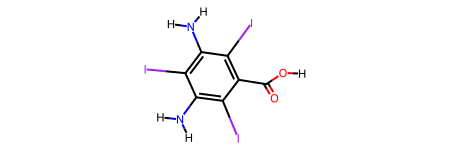

In [60]:
low_rd_mol 


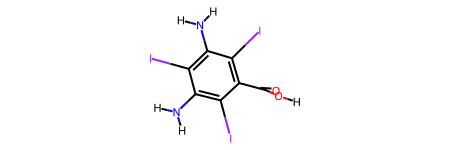

In [61]:
low_rd_mol_hexane

In [62]:
with open("Nc1c(I)c(N)c(I)c(C(=O)O)c1I_conf_in_H2O_and_Hexane.pkl", "wb") as f:
    pickle.dump((low_rd_mol, low_rd_mol_hexane), f)

In [63]:
with open('Nc1c(I)c(N)c(I)c(C(=O)O)c1I_conf_in_H2O_and_Hexane.pkl','rb') as f:
    two_rdkit = pickle.load(f)

In [68]:
pwd

'/Users/zhangyici/Desktop/Autumn/Computer_Vision/CV_Final_Project'

# Evaluation

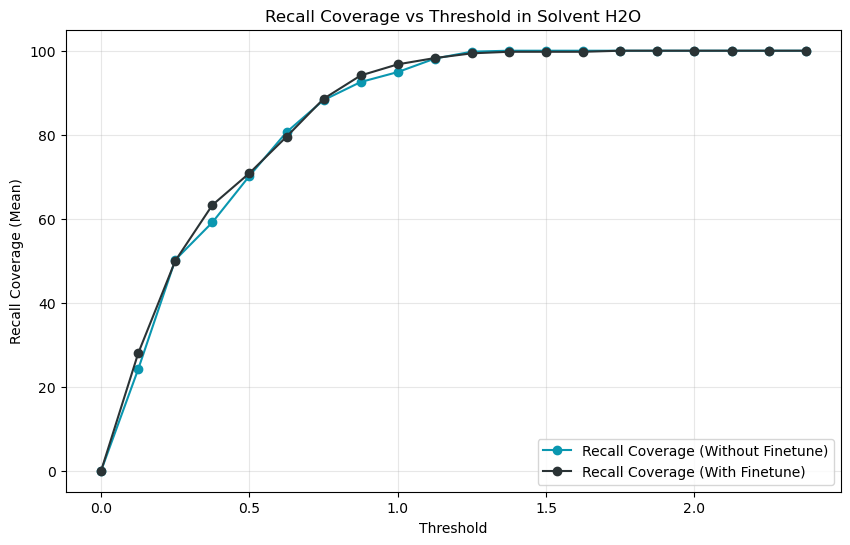

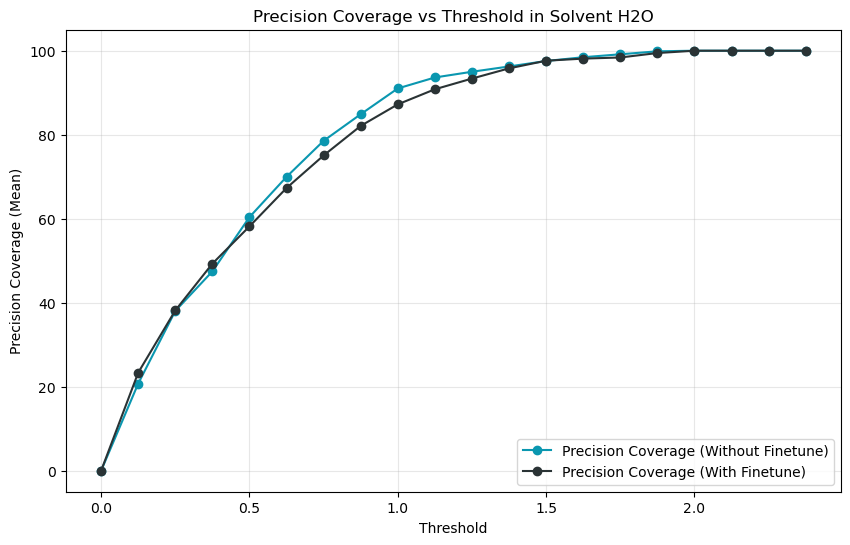

In [23]:
# 水
# Re-import necessary libraries and reinitialize data after environment reset
import matplotlib.pyplot as plt
import numpy as np

# Data for plotting
thresholds = np.arange(0.0, 2.5, 0.125)  # Example thresholds

# Recall Coverage (mean) for both models
recall_coverage_without_finetune = [0.00, 24.18, 50.21, 59.13, 70.20, 80.62, 88.25, 92.55, 94.92, 98.13, 99.78, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00,100]
recall_coverage_with_finetune = [0.00, 27.97, 49.98, 63.26, 70.86, 79.52, 88.56, 94.11, 96.76, 98.26, 99.38, 99.75, 99.75, 99.75, 100.00, 100.00, 100.00, 100.00, 100.00,100]

# Precision Coverage (mean) for both models
precision_coverage_without_finetune = [0.00, 20.75, 38.04, 47.46, 60.38, 69.97, 78.55, 84.88, 91.02, 93.63, 94.99, 96.25, 97.55, 98.45, 99.15, 99.86, 100.00, 100.00, 100.00,100]
precision_coverage_with_finetune = [0.00, 23.35, 38.16, 49.30, 58.17, 67.31, 75.06, 82.10, 87.23, 90.82, 93.37, 95.80, 97.62, 98.12, 98.39, 99.45, 100.00, 100.00, 100.00,100]

# Plot Recall Coverage vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_coverage_without_finetune, label='Recall Coverage (Without Finetune)', marker='o', color = '#0A97B0')
plt.plot(thresholds, recall_coverage_with_finetune, label='Recall Coverage (With Finetune)', marker='o', color = '#2A3335')
plt.xlabel('Threshold')
plt.ylabel('Recall Coverage (Mean)')
plt.title('Recall Coverage vs Threshold in Solvent H2O')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

# Plot Precision Coverage vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_coverage_without_finetune, label='Precision Coverage (Without Finetune)', marker='o', color = '#0A97B0')
plt.plot(thresholds, precision_coverage_with_finetune, label='Precision Coverage (With Finetune)', marker='o', color = '#2A3335')
plt.xlabel('Threshold')
plt.ylabel('Precision Coverage (Mean)')
plt.title('Precision Coverage vs Threshold in Solvent H2O')
plt.legend(loc='lower right')
plt.grid(alpha = 0.3)
plt.show()


In [28]:
# hexane
# Model 1: Without finetune
recall_coverage_mean_without_finetune = [
    0.00, 20.93, 36.36, 46.98, 58.10, 72.17, 85.39, 92.41, 95.82, 96.79, 
    97.01, 98.31, 98.61, 98.81, 98.81, 98.81, 98.81, 98.81, 98.81, 98.81
]

precision_coverage_mean_without_finetune = [
    0.00, 17.70, 30.28, 39.69, 48.06, 62.08, 73.69, 80.61, 85.09, 88.47, 
    90.90, 92.59, 93.87, 95.71, 96.73, 97.52, 98.18, 98.29, 98.34, 98.36
]

# Model 2: With finetune
recall_coverage_mean_with_finetune = [
    0.00, 23.54, 42.90, 53.03, 62.53, 79.73, 88.51, 92.61, 94.28, 96.47, 
    97.47, 98.07, 98.81, 98.81, 98.81, 98.81, 98.81, 98.81, 98.81, 98.81
]

precision_coverage_mean_with_finetune = [
    0.00, 19.15, 35.21, 43.51, 50.99, 64.75, 74.85, 82.27, 87.58, 90.09, 
    91.86, 93.64, 94.99, 96.11, 96.91, 97.56, 97.90, 98.33, 98.35, 98.66
]

In [29]:
thresholds = np.arange(0.0, 2.5, 0.125)  # Example thresholds

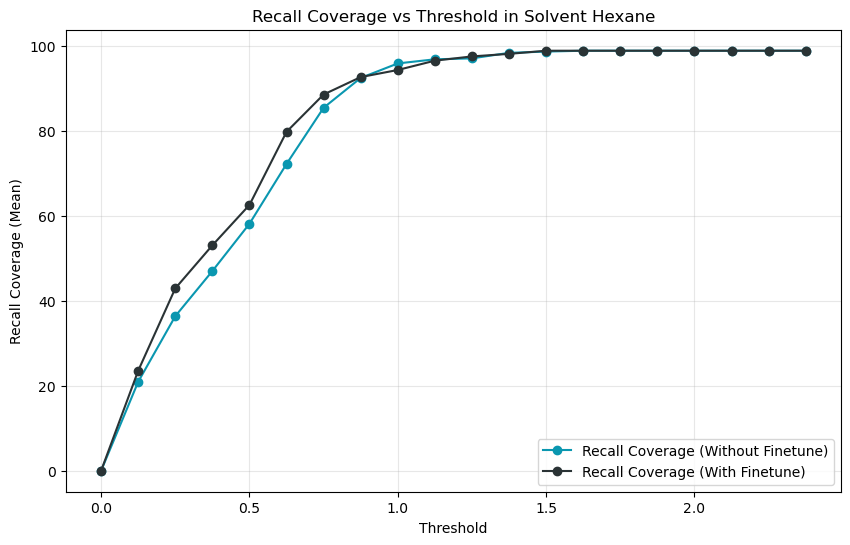

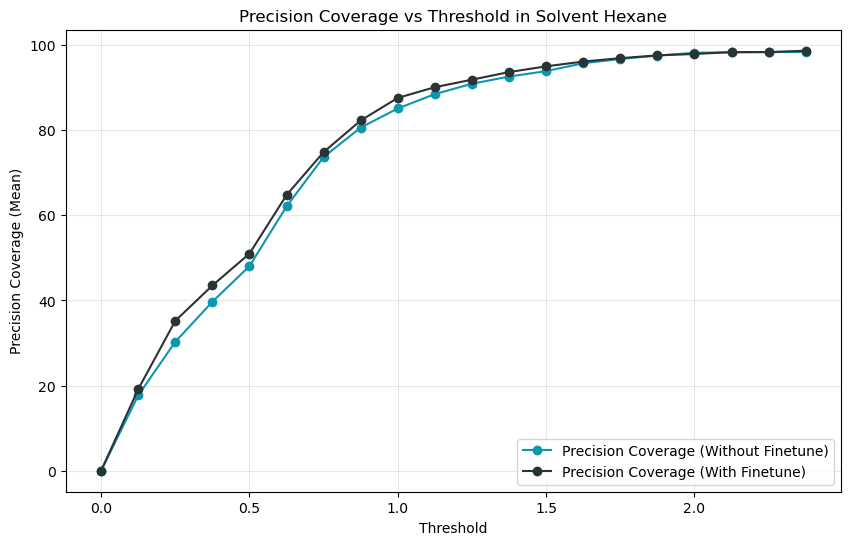

In [30]:
# Plot Recall Coverage vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, recall_coverage_mean_without_finetune, label='Recall Coverage (Without Finetune)', marker='o', color = '#0A97B0')
plt.plot(thresholds, recall_coverage_mean_with_finetune, label='Recall Coverage (With Finetune)', marker='o', color = '#2A3335')
plt.xlabel('Threshold')
plt.ylabel('Recall Coverage (Mean)')
plt.title('Recall Coverage vs Threshold in Solvent Hexane')
plt.legend()
plt.grid(alpha = 0.3)
plt.show()

# Plot Precision Coverage vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_coverage_mean_without_finetune, label='Precision Coverage (Without Finetune)', marker='o', color = '#0A97B0')
plt.plot(thresholds, precision_coverage_mean_with_finetune, label='Precision Coverage (With Finetune)', marker='o', color = '#2A3335')
plt.xlabel('Threshold')
plt.ylabel('Precision Coverage (Mean)')
plt.title('Precision Coverage vs Threshold in Solvent Hexane')
plt.legend(loc='lower right')
plt.grid(alpha = 0.3)
plt.show()

# Visualization

first visulization

In [104]:
directory_path = 'shui/[H]OC(=O)C1=C([H])[C@@]([H])(OP(=O)(O[H])O[H])C([H])([H])C([H])([H])C1([H])[H].pickle'
with open(directory_path, 'rb') as f:
    mol = pickle.load(f)

In [117]:
smile_list_all = [mol['smiles']]

In [115]:
number_conf_list = [len(mol['conformers'])]

In [113]:
mol_ = Chem.MolFromSmiles(mol['smiles'])
canonical_smi = Chem.MolToSmiles(mol_, isomericSmiles=False)

In [119]:
cro_list_all = [canonical_smi]

In [121]:
data_visualization = pd.DataFrame({
    "smiles": smile_list_all,
    "n_conformers": number_conf_list,
    "corrected_smiles": cro_list_all
    })

In [123]:
output_path = 'torsional-diffusion/visulization_1.csv'  # Specify the desired file path
data_visualization.to_csv(output_path, index=False)

print(f"CSV file saved to: {output_path}")

CSV file saved to: torsional-diffusion/visulization_1.csv


In [146]:
def get_lowest_energy_rd_mol(predicted_pickle, key):
    low_energy = 99999999999
    low_rd_mol = None
    for rd_mol in predicted_pickle[key]:
        energy = mmff_energy(rd_mol)
        if energy <= low_energy:
            low_energy = energy
            low_rd_mol = rd_mol
    return low_rd_mol, low_energy

In [292]:
def get_lowest_energy_rd_mol_list(rd_mol_list):
    low_energy = 99999999999
    low_rd_mol = None
    for rd_mol in rd_mol_list:
        try:
            energy = mmff_energy(rd_mol)
            if energy <= low_energy:
                low_energy = energy
                low_rd_mol = rd_mol
        except:
            continue
    return low_rd_mol, low_energy

In [218]:
with open('torsional-diffusion/drugs_20steps_shu_visu1i.pkl', 'rb') as f:
    predicted_shui_visu_1 = pickle.load(f)

In [219]:
predicted_shui_visu_1.keys()

dict_keys(['O=C(O)C1=CC(OP(=O)(O)O)CCC1'])

In [220]:
low_rd_mol_visu_shui, low_energy_shui = get_lowest_energy_rd_mol(predicted_shui_visu_1, 'O=C(O)C1=CC(OP(=O)(O)O)CCC1')

In [221]:
# visulize visu_1 in H2O
view_mol_3d(low_rd_mol_visu_shui)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [222]:
low_energy_shui

-196.59105685055687

In [240]:
with open('torsional-diffusion/drugs_20steps_hexane_visu1.pkl', 'rb') as f:
    predicted_hexane_visu_1 = pickle.load(f)

In [241]:
low_rd_mol_visu_hexane, low_energy_hexane = get_lowest_energy_rd_mol(predicted_hexane_visu_1, 'O=C(O)C1=CC(OP(=O)(O)O)CCC1')

In [242]:
low_energy_hexane

-193.56622584561313

In [243]:
view_mol_3d(low_rd_mol_visu_hexane)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [228]:
# 找第一个分析的ground truth in H20
directory_path = 'shui/[H]OC(=O)C1=C([H])[C@@]([H])(OP(=O)(O[H])O[H])C([H])([H])C([H])([H])C1([H])[H].pickle'
with open(directory_path, 'rb') as f:
    visu1_gt_shui = pickle.load(f)


In [229]:
conf_visu1_shui_gt_list = []

In [230]:
for conf in visu1_gt_shui['conformers']:
    conf_visu1_shui_gt_list.append(conf['rd_mol'])

In [231]:
visu1_shui_gt_rd_mol, visu1_shui_gt_energy = get_lowest_energy_rd_mol_list(conf_visu1_shui_gt_list)

In [232]:
# groud truth in 水
view_mol_3d(visu1_shui_gt_rd_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [233]:
# gt in hexane
directory_path = 'hexane_groupby/[H]OC(=O)C1=C([H])[C@@]([H])(OP(=O)(O[H])O[H])C([H])([H])C([H])([H])C1([H])[H].pickle'
with open(directory_path, 'rb') as f:
    visu1_gt_hexane = pickle.load(f)


In [234]:
conf_visu1_hexane_gt_list = []

In [235]:
for conf in visu1_gt_hexane['conformers']:
    conf_visu1_hexane_gt_list.append(conf['rd_mol'])

In [236]:
visu1_hexane_gt_rd_mol, visu1_hexane_gt_energy = get_lowest_energy_rd_mol_list(conf_visu1_hexane_gt_list)

In [237]:
view_mol_3d(visu1_hexane_gt_rd_mol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [213]:
visu1_hexane_gt_energy

-219.1981311710332

In [214]:
visu1_shui_gt_energy

-219.1981311710332

In [238]:
dump_pickle_dict_visu1 = {}

In [244]:
dump_pickle_dict_visu1['smile of the molecular'] = '[H]OC(=O)C1=C([H])[C@@]([H])(OP(=O)(O[H])O[H])C([H])([H])C([H])([H])C1([H])[H]'
dump_pickle_dict_visu1['finetune model predicted in H2O'] = low_rd_mol_visu_shui
dump_pickle_dict_visu1['ground truth in H2O'] = visu1_shui_gt_rd_mol
dump_pickle_dict_visu1['finetune model predicted in Hexane'] = low_rd_mol_visu_hexane
dump_pickle_dict_visu1['ground truth in Hexane'] = visu1_hexane_gt_rd_mol

In [250]:
with open('torsional-diffusion/visu_on_[H]OC(=O)C1=C([H])[C@@]([H])(OP(=O)(O[H])O[H])C([H])([H])C([H])([H])C1([H])[H].pkl', 'wb') as f:
    pickle.dump(dump_pickle_dict_visu1, f)

### Visualization

##### second molecular visulization

##### H2O and Hexane groud true

In [305]:
mol2_shui_gt_path = 'shui/[H]C([H])([H])C([H])([H])OP(=O)(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H].pickle'
with open(mol2_shui_gt_path, 'rb') as f:
    mol_2_shui_gt = pickle.load(f)

In [306]:
mol2_shui_gt_rdmol_list = [conf['rd_mol'] for conf in mol_2_shui_gt['conformers']]

In [309]:
mol2_shui_gt_rdmol, mol2_shui_gt_energy = get_lowest_energy_rd_mol_list(mol2_shui_gt_rdmol_list)

In [347]:
view_mol_3d(mol2_shui_gt_rdmol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [313]:
mol2_hexane_gt_path = 'hexane_groupby/[H]C([H])([H])C([H])([H])OP(=O)(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H].pickle'
with open(mol2_hexane_gt_path, 'rb') as f:
    mol_2_hexane_gt = pickle.load(f)

In [314]:
mol2_hexane_gt_rdmol_list = [conf['rd_mol'] for conf in mol_2_hexane_gt['conformers']]

In [316]:
mol2_hexane_gt_rdmol, mol2_hexane_gt_energy = get_lowest_energy_rd_mol_list(mol2_hexane_gt_rdmol_list)

In [348]:
view_mol_3d(mol2_hexane_gt_rdmol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [326]:
smiles_mol2 = ['[H]C([H])([H])C([H])([H])OP(=O)(C([H])([H])C([H])([H])C([H])([H])[H])C([H])([H])C([H])([H])C([H])([H])[H]']
cros_smiles_mol2 = ['CCCP(=O)(CCC)OCC']
number_conf_mol2 = [206]

In [327]:
data_visualization_mol2 = pd.DataFrame({
    "smiles": smiles_mol2,
    "n_conformers": number_conf_mol2,
    "corrected_smiles": cros_smiles_mol2
    })

In [329]:
output_path = 'torsional-diffusion/visulization_mol2.csv'  # Specify the desired file path
data_visualization_mol2.to_csv(output_path, index=False)

print(f"CSV file saved to: {output_path}")

CSV file saved to: torsional-diffusion/visulization_mol2.csv


In [330]:
mol2_shui_ft_path = 'torsional-diffusion/drugs_20steps_shui_mol2.pkl'
with open(mol2_shui_ft_path, 'rb') as f:
    mol2_shui_ft = pickle.load(f)

In [334]:
mol2_shui_ft_rdmol, mol2_shui_ft_energy = get_lowest_energy_rd_mol_list(mol2_shui_ft['CCCP(=O)(CCC)OCC'])

In [344]:
mol2_shui_ft_energy

-2.6346380125135145

In [338]:
view_mol_3d(mol2_shui_ft_rdmol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [339]:
mol2_hexane_ft_path = 'torsional-diffusion/drugs_20steps_hexane_mol2.pkl'
with open(mol2_hexane_ft_path, 'rb') as f:
    mol2_hexane_ft = pickle.load(f)

In [342]:
mol2_hexane_ft_rdmol, mol2_hexane_ft_energy = get_lowest_energy_rd_mol_list(mol2_hexane_ft['CCCP(=O)(CCC)OCC'])

In [343]:
mol2_hexane_ft_energy

-3.216782988895858

In [346]:
view_mol_3d(mol2_hexane_ft_rdmol)

3Dmol.js failed to load for some reason. Please check your browser console for error messages.